In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import pandas as pd
import numpy as np

np.random.seed(0)

In [ ]:
df = pd.read_excel('/content/drive/My Drive/00-UII/RESEARCH/2020 HIBAH KOLABORASI/COPY CODE FATHAN/DATASET/Copy of 16K_Dataset.xlsx')

In [ ]:
'''
text = df['Text'].values
label = df['Label'].values
'''
text = df.iloc[:,1].values
label = df.iloc[:,2].values

In [ ]:
df.head()

,Unnamed: 0,Text,Label
0,0,sing kudu dimungsuhi kuwi udu manungsane nangi...,Jawa Standar
1,1,mesthi panjenengan wis nate krungu pitutur iki...,Jawa Standar
2,2,rejeki wis pinesthi dening gusti dicegat kadan...,Jawa Standar
3,3,wong kang sengsara uripe jalaran ana rong warn...,Jawa Standar
4,4,wanita sing ayu iku ora mung ayu rupane manis ...,Jawa Standar


In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

max_seq_len = max([len(i.split()) for i in text])
print(max_seq_len)

X = tokenizer.texts_to_sequences(text)
X = pad_sequences(X, maxlen = max_seq_len)
y = pd.get_dummies(label)
print("Shape of data tensor:", X.shape)
print("Shape of label tensor:",y.shape)

53
Shape of data tensor: (16500, 53)
Shape of label tensor: (16500, 3)


In [ ]:
vocab = max([len(tokenizer.word_index)])+1
vocab

30172

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, GlobalAveragePooling1D, GlobalMaxPooling1D, BatchNormalization, Concatenate, Input, Embedding, LSTM, Attention, Dense, Dropout, Bidirectional, Flatten, Conv1D, MaxPool1D, Reshape, SpatialDropout1D, UpSampling1D, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import os

In [ ]:
file_path = '/content/drive/My Drive/00-UII/RESEARCH/2020 HIBAH KOLABORASI/COPY CODE FATHAN/'
ep = 10
#bsize = 128
n_split = 5

In [ ]:
def plot_history(histories, key='loss'):
  plt.figure(figsize=(16,10))
  
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
          label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    plt.xlim([0,max(history.epoch)])
        
def evaluation(model, X, y):
  loss, acc = model.evaluate(X, y, verbose=0)
  print("Accuracy: %.4f" % acc)
  print("Loss: %.4f" % loss)

  return loss, acc

from sklearn.model_selection import KFold
performance_result = []

def train_model(X, y, n_split, model, model_name, epochs):
  acc_results = []
  loss_results = []
  kf = KFold(n_split, shuffle=True, random_state=1)
  for train_index, test_index in kf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[(test_index)]

    model = model
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))
    loss, acc = evaluation(model, X_test, y_test)
    acc_results.append(acc)
    loss_results.append(loss)
    #acc_mean = np.mean(acc_results)

    plot_history([('Model', history)])
    filename = model_name
    the_path = os.path.join(file_path, 'NEW_MODEL', filename+'.h5')
    model.save(the_path)
  
  acc_avg = round(np.mean(acc_results), 4)
  acc_std = round(np.std(acc_results), 4)
  loss_avg = round(np.mean(loss_results), 4)
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: %.4f (+/- %.4f) ' % (acc_avg, acc_std))
  print(f'> Loss: %.4f' %loss_avg)
  print('------------------------------------------------------------------------')

  return acc_avg, acc_std, loss_avg

In [ ]:
import keras.backend as K

In [ ]:
def dot_product(x, kernel):
  """
  Wrapper for dot product operation, in order to be compatible with both
  Theano and Tensorflow
  Args:
      x (): input
      kernel (): weights
  Returns:
  """
  if K.backend() == 'tensorflow':
      return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
  else:
      return K.dot(x, kernel)


In [ ]:
class AttentionWithContext(keras.layers.Layer):
  def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

  def get_config(self):
    config = super().get_config().copy()
    config.update({
            'W_regularizer': self.W_regularizer,
            'u_regularizer': self.u_regularizer,
            'b_regularizer': self.b_regularizer,
            'W_constraint': self.W_constraint,
            'u_constraint': self.u_constraint,
            'b_constraint': self.b_constraint,
            'bias': self.bias,
    })
    return config
    
  def build(self, input_shape):
      assert len(input_shape) == 3

      self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                initializer=self.init,
                                name='{}_W'.format(self.name),
                                regularizer=self.W_regularizer,
                                constraint=self.W_constraint)
      if self.bias:
          self.b = self.add_weight(shape=(input_shape[-1],),
                                    initializer='zero',
                                    name='{}_b'.format(self.name),
                                    regularizer=self.b_regularizer,
                                    constraint=self.b_constraint)

      self.u = self.add_weight(shape=(input_shape[-1],),
                                initializer=self.init,
                                name='{}_u'.format(self.name),
                                regularizer=self.u_regularizer,
                                constraint=self.u_constraint)

      super(AttentionWithContext, self).build(input_shape)

  def compute_mask(self, input, input_mask=None):
      # do not pass the mask to the next layers
      return None

  def call(self, x, mask=None):
      uit = dot_product(x, self.W)

      if self.bias:
          uit += self.b

      uit = K.tanh(uit)
      ait = dot_product(uit, self.u)

      a = K.exp(ait)

      # apply mask after the exp. will be re-normalized next
      if mask is not None:
          # Cast the mask to floatX to avoid float64 upcasting in theano
          a *= K.cast(mask, K.floatx())

      # in some cases especially in the early stages of training the sum may be almost zero
      # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
      # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
      a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

      a = K.expand_dims(a)
      weighted_input = x * a
      return K.sum(weighted_input, axis=1)

  def compute_output_shape(self, input_shape):
      return input_shape[0], input_shape[-1]

###CNN-BiLSTM with Attention

In [ ]:
def cblsattn():
  inp = Input(shape=(max_seq_len,))
  x = Embedding(input_dim=vocab, output_dim=100, input_length=max_seq_len)(inp)
  x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
  x = MaxPool1D(pool_size=2)(x)
  x = BatchNormalization()(x)
  x = Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(x)
  x = AttentionWithContext()(x)
  x = Dense(32)(x)
  x = Dense(3, activation="softmax")(x)
  model = Model(inputs=inp, outputs=x)
  model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['acc'])
  print(model.summary())
  img_path = os.path.join(file_path, 'IMAGE_MODEL', 'cblsattn.png')
  plot_model(model, to_file=img_path, show_shapes=True)
  return model

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 53)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 53, 100)           3017200   
_________________________________________________________________
conv1d (Conv1D)              (None, 53, 32)            9632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 26, 32)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 32)            128       
_________________________________________________________________
bidirectional (Bidirectional (None, 26, 64)            16640     
_________________________________________________________________
attention_with_context (Atte (None, 64)               

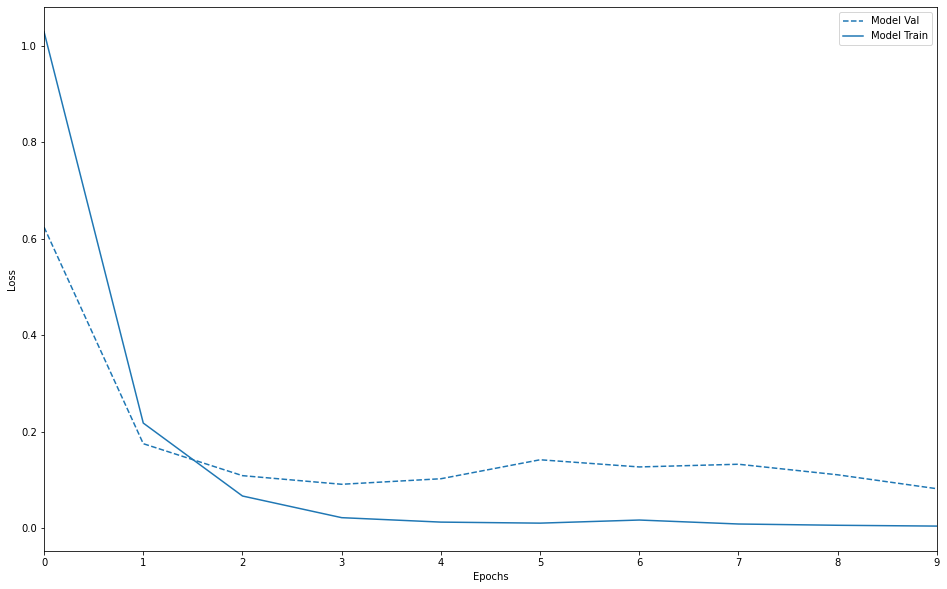

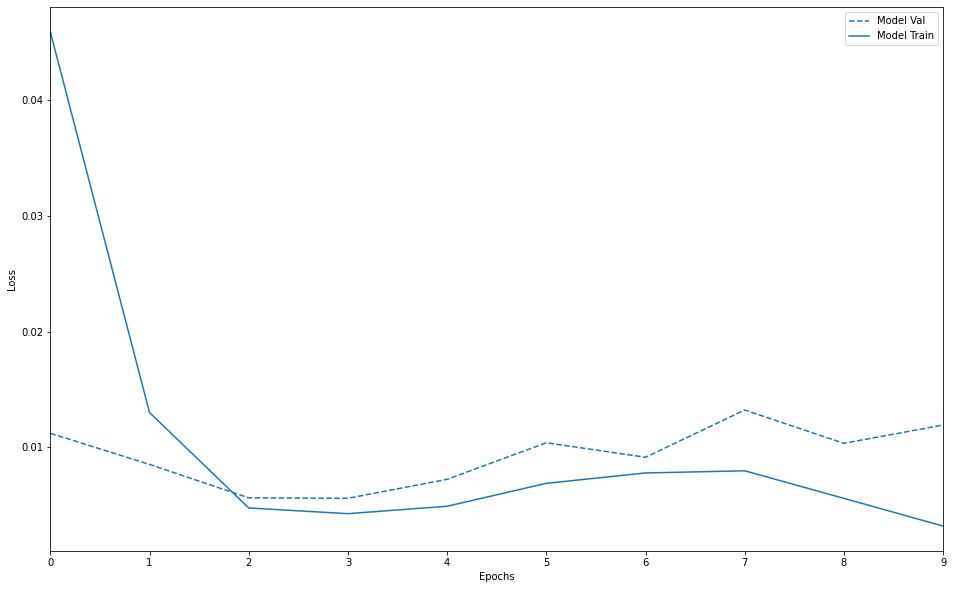

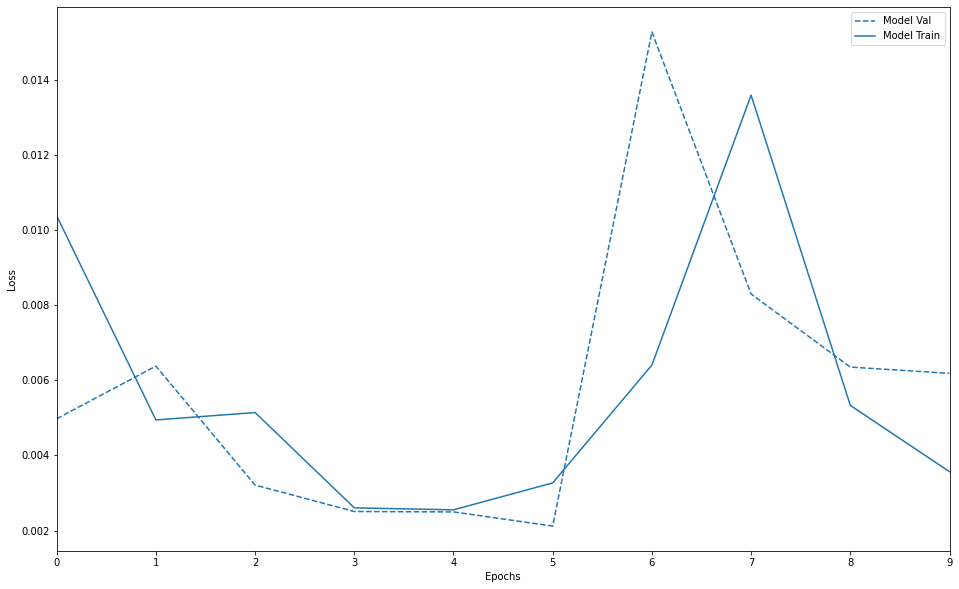

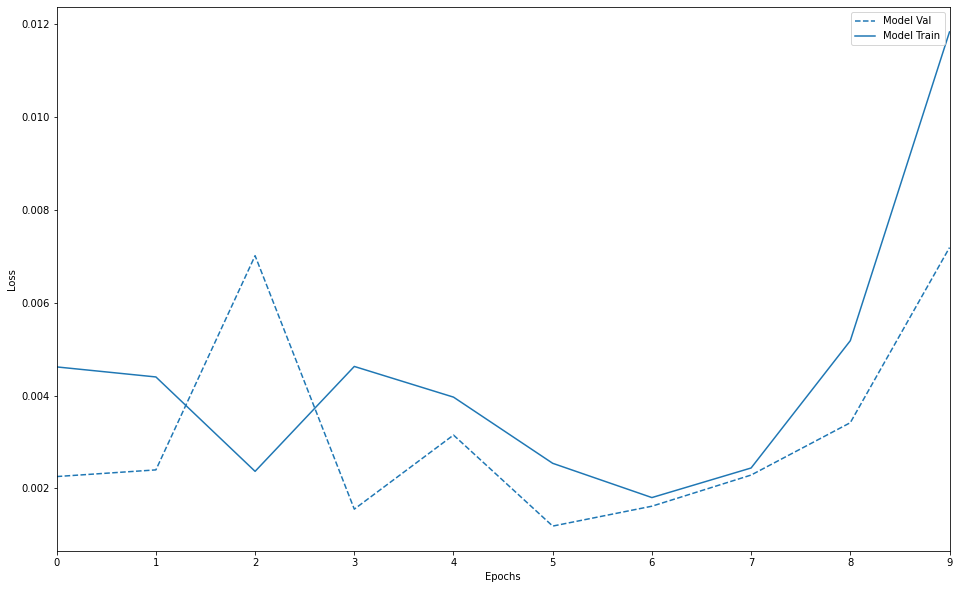

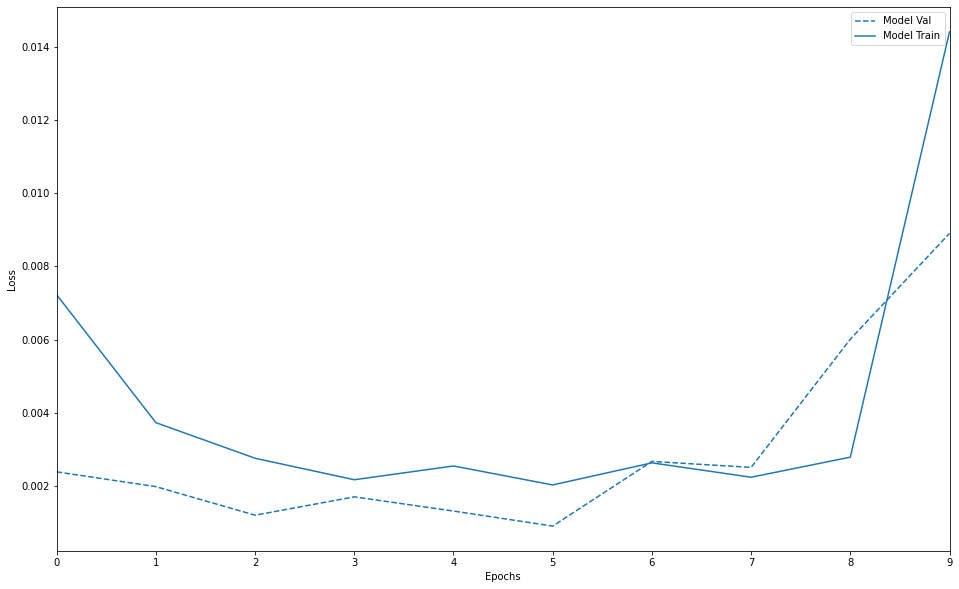

In [ ]:
modelname = 'cblsattn'
cblsattn_result = train_model(X, y, n_split=n_split, model=cblsattn(), model_name=modelname, epochs=ep)
p0 = (modelname, cblsattn_result[0], cblsattn_result[1], cblsattn_result[2])
performance_result.append(p0)

In [ ]:
def cblsattn_1():
  inp = Input(shape=(max_seq_len,))
  x = Embedding(input_dim=vocab, output_dim=100, input_length=max_seq_len)(inp)
  x = SpatialDropout1D(0.2)(x)
  x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
  x = MaxPool1D(pool_size=2)(x)
  x = Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(x)
  x = AttentionWithContext()(x)
  x = Dense(32)(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x) 
  x = Dense(3, activation="softmax")(x)
  model = Model(inputs=inp, outputs=x)
  model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['acc'])
  print(model.summary())
  img_path = os.path.join(file_path, 'IMAGE_MODEL', 'cblsattn_1.png')
  plot_model(model, to_file=img_path, show_shapes=True)
  return model

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 53)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 53, 100)           3017200   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 53, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 53, 32)            9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 26, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 26, 64)            16640     
_________________________________________________________________
attention_with_context_1 (At (None, 64)               

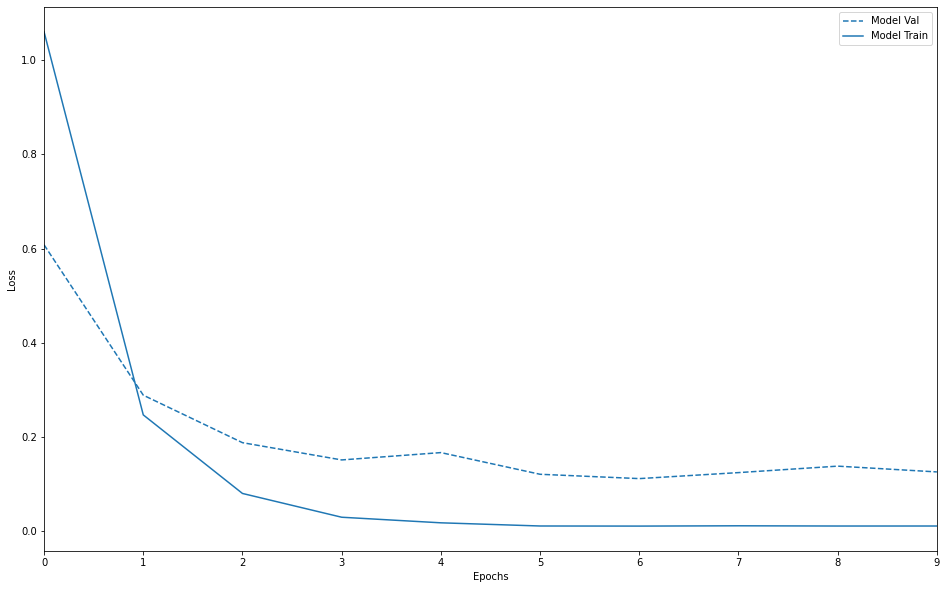

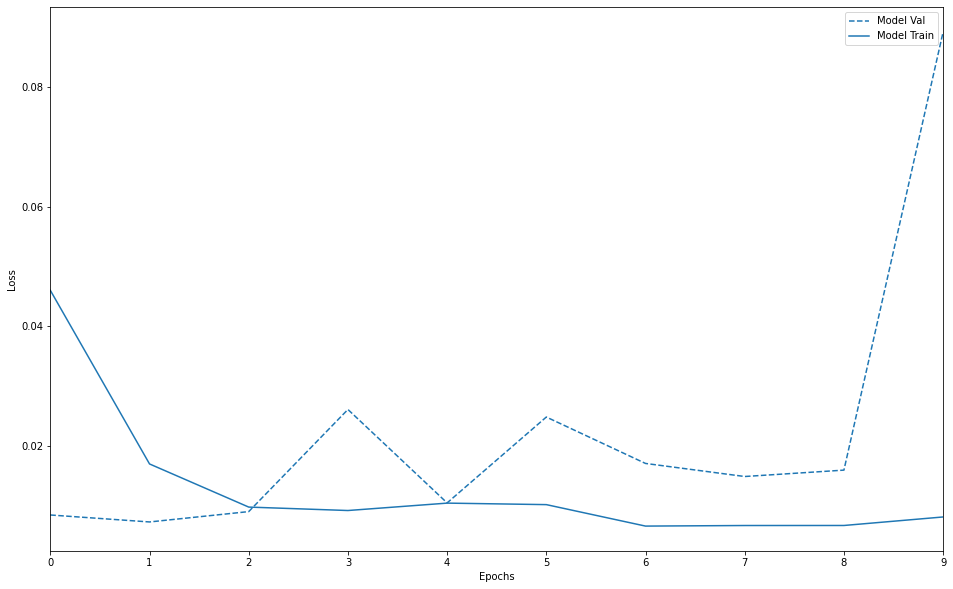

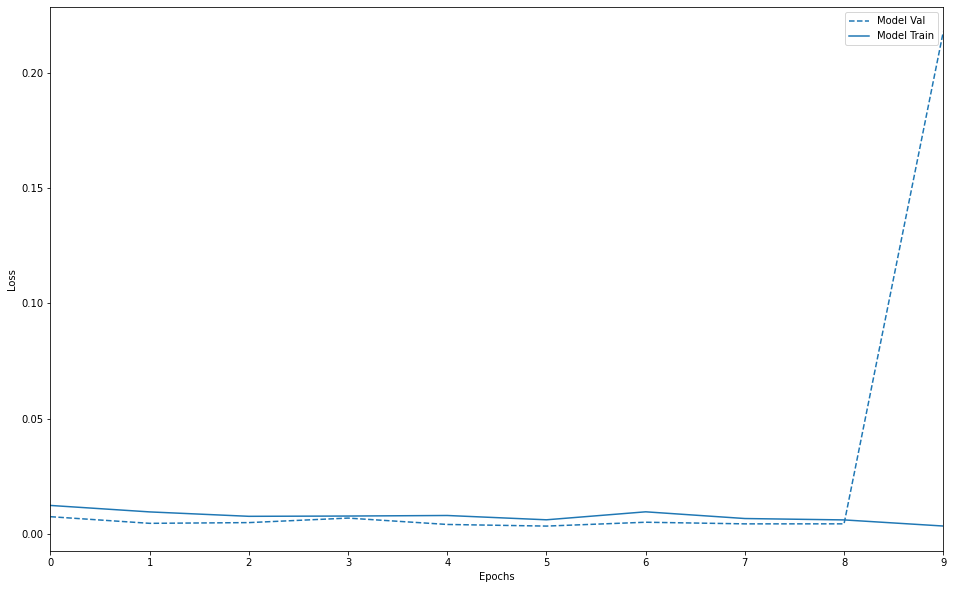

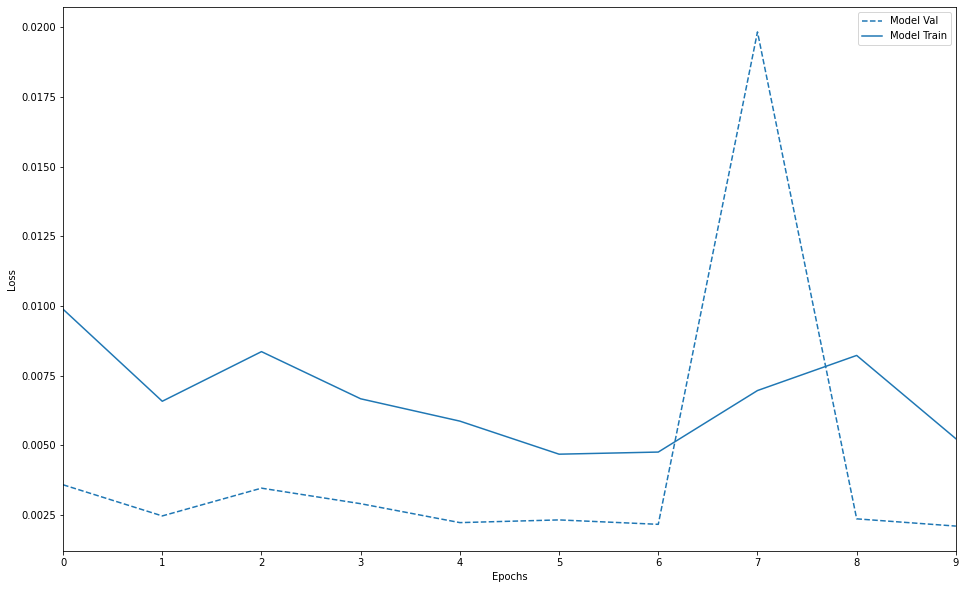

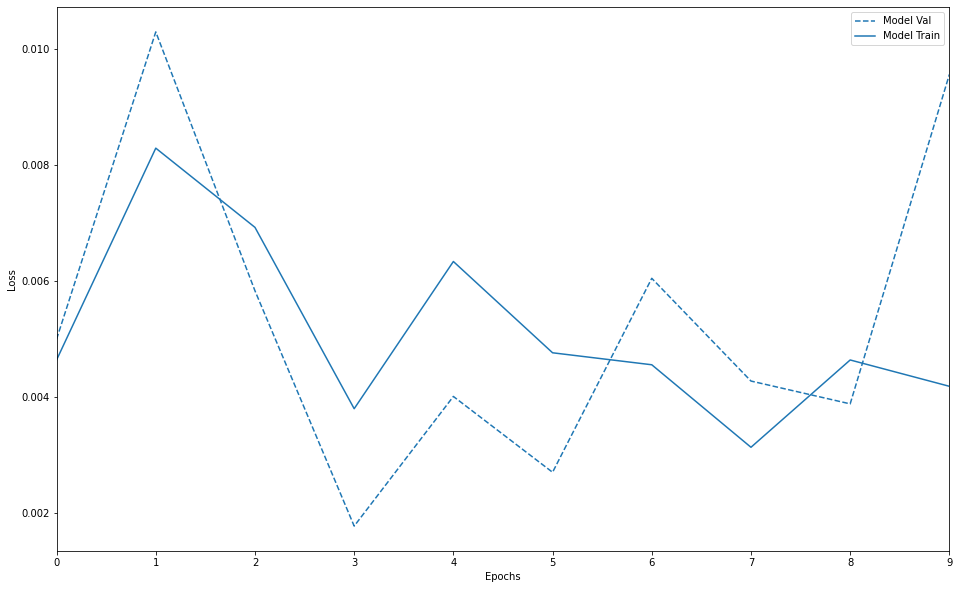

In [ ]:
modelname = 'cblsattn_1'
cblsattn_result = train_model(X, y, n_split=n_split, model=cblsattn_1(), model_name=modelname, epochs=ep)
p1 = (modelname, cblsattn_result[0], cblsattn_result[1], cblsattn_result[2])
performance_result.append(p1)

In [ ]:
df = pd.DataFrame.from_records(performance_result, columns=['Model','Average Accuracy','Standard Dev Accuracy','Average Loss'])
print(df)

        Model  Average Accuracy  Standard Dev Accuracy  Average Loss
0    cblsattn            0.9944                 0.0092        0.0231
1  cblsattn_1            0.9792                 0.0200        0.0889


In [ ]:
df.to_excel('/content/drive/My Drive/00-UII/RESEARCH/2020 HIBAH KOLABORASI/COPY CODE FATHAN/RESULT WITH CV/DeepLearning_Attention.xlsx')